In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import umap
import keras
import seaborn as sns
import matplotlib.pyplot as plt
from keras import layers, regularizers
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [2]:
# Define scaling approach:
# 1. log10 transformation
# 2. standard scaling
# 3. clip to maximum range
# 4. min-max scale for deep learning
standard_scaler = StandardScaler()
min_max_scaler = MinMaxScaler(feature_range=(-1,1)) 
cycif_scale_func = lambda d: min_max_scaler.fit_transform( standard_scaler.fit_transform(np.log10(d)).clip(min=-10, max=10) )

def load_cycif_sample(file_name, scale_fn, patient_id, bx_name):
    sample_df = pd.read_csv(file_name, header=0)
    sample_df['patient_id'] = patient_id
    sample_df['bx'] = bx_name
    sample_df['scaled'] = 'N'
    sample_df_scaled = sample_df.copy()
    marker_cols = sample_df.filter(regex="nucleiMasks$").filter(regex="^(?!(DAPI|AF))").columns
    sample_df_scaled[marker_cols] = scale_fn(sample_df[marker_cols])
    sample_df_scaled['scaled'] = 'Y'
    sample_df_all = pd.concat([sample_df, sample_df_scaled])
    return sample_df_all

In [3]:
# Load the dataset.
p9_2_bx1_filename = "./9_2_bx1_HMS_cycif_tumor_panel_BEMS0000342251.csv"
p9_2_bx1_df = load_cycif_sample(p9_2_bx1_filename, cycif_scale_func, "9-2", 1)
p9_2_bx1_df.head()

CellID  DAPI_1_cellMasks  AF488_cellMasks  AF555_cellMasks  \
0       1      18399.201646      1938.308642       951.753086   
1       2      13872.480000      1933.280000       895.360000   
2       3      10940.505263     11353.252632       788.294737   
3       4      10590.968254      8699.428571       714.428571   
4       5      16300.946429      8819.517857       916.303571   

   AF647_cellMasks  DAPI_2_cellMasks  ERK1_1_cellMasks  ERK1_2_cellMasks  \
0      1536.115226       6840.255144       1285.267490        883.053498   
1      1496.160000       6647.280000       1241.400000        864.480000   
2      4166.000000        119.452632        898.242105        379.168421   
3      2570.920635        117.904762        926.841270        395.603175   
4      2854.267857         74.678571        884.607143        391.196429   

   RAD51_cellMasks  DAPI_3_cellMasks  ...  CK14_nucleiMasks  AR_nucleiMasks  \
0      1218.925926      14302.860082  ...       2164.238683      379.246914   
1      1408.320000      14804.480000  ...       2175.960000      381.560000   
2       823.926316        143.189474  ...       2197.578947      385.263158   
3       832.333333        130.253968  ...       2167.571429      389.269841   
4       792.589286         72.625000  ...       2162.750000      387.678571   

   cPARP_nucleiMasks  DAPI_8_nucleiMasks  CK17_nucleiMasks  CK7_nucleiMasks  \
0        2489.053498          198.650206       2298.633745       141.518519   
1        2500.080000          192.200000       2289.400000       141.720000   
2        2720.484211          198.568421       2344.273684       146.221053   
3        2527.301587          191.000000       2328.047619       141.492063   
4        2485.535714          183.214286       2314.357143       140.392857   

   HER2_nucleiMasks  patient_id  bx  scaled  
0       2568.308642         9-2   1       N  
1       2591.960000         9-2   1       N  
2       2580.915789         9-2   1       N  
3       2569.523810         9-2   1       N  
4       2573.964286         9-2   1       N  

[5 rows x 79 columns]

In [4]:
# Create the VAE using the approach outlined at https://keras.io/examples/generative/vae/

# Create sampling layer.
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a cell."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [5]:
# Build the encoder.

marker_cols = p9_2_bx1_df.filter(regex="nucleiMasks$").filter(regex="^(?!(DAPI|AF))").columns
p9_2_bx1_df = p9_2_bx1_df[p9_2_bx1_df.scaled == 'Y']
markers_df = p9_2_bx1_df[marker_cols].reset_index(drop=True)

inputs_dim = markers_df.shape[1]
latent_dim = 5
activation = "linear"

encoder_inputs = keras.Input(shape=(inputs_dim,))
x = layers.Dense(inputs_dim, activation=activation)(encoder_inputs)
x = layers.Dense(inputs_dim / 2, activation=activation)(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 21)]         0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 21)           462         input_1[0][0]                    
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 10)           220         dense[0][0]                      
__________________________________________________________________________________________________
z_mean (Dense)                  (None, 5)            55          dense_1[0][0]                    
____________________________________________________________________________________________

In [6]:
# Build the decoder.
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(inputs_dim / 2, activation=activation)(latent_inputs)
decoder_outputs = layers.Dense(inputs_dim)(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 5)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                60        
_________________________________________________________________
dense_3 (Dense)              (None, 21)                231       
Total params: 291
Trainable params: 291
Non-trainable params: 0
_________________________________________________________________


In [7]:
# Define VAE as a Model with a custom train_step
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss_fn = keras.losses.MeanSquaredError()
            reconstruction_loss = reconstruction_loss_fn(data, reconstruction)
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

    def call(self, inputs):
        z_mean, z_log_var, z = self.encoder(inputs)
        print (self.decoder(z))
        return self.decoder(z)

In [8]:
# Split into train, test.
X_dev,   X_val  = train_test_split(markers_df, test_size=0.05, random_state=1, shuffle=True)
X_train, X_test = train_test_split(X_dev,  test_size=0.25, random_state=1)

# Create the VAR, compile, and run.
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
# FIXME: validation_split is not working-need to fix this by implementing call() function in VAE class correctly.
history = vae.fit(X_train, epochs=100, batch_size=128) # validation_split=0.1)

Epoch 1/100
154/154 [==============================] - 1s 1ms/step - loss: 1.5284 - reconstruction_loss: 0.5024 - kl_loss: 0.3551
Epoch 2/100
154/154 [==============================] - 0s 941us/step - loss: 0.2939 - reconstruction_loss: 0.1968 - kl_loss: 0.0462
Epoch 3/100
154/154 [==============================] - 0s 975us/step - loss: 0.1554 - reconstruction_loss: 0.1254 - kl_loss: 0.0200
Epoch 4/100
154/154 [==============================] - 0s 978us/step - loss: 0.1283 - reconstruction_loss: 0.1150 - kl_loss: 0.0114
Epoch 5/100
154/154 [==============================] - 0s 959us/step - loss: 0.1227 - reconstruction_loss: 0.1129 - kl_loss: 0.0073
Epoch 6/100
154/154 [==============================] - 0s 918us/step - loss: 0.1182 - reconstruction_loss: 0.1124 - kl_loss: 0.0050
Epoch 7/100
154/154 [==============================] - 0s 940us/step - loss: 0.1158 - reconstruction_loss: 0.1121 - kl_loss: 0.0036
Epoch 8/100
154/154 [==============================] - 0s 944us/step - loss: 0

In [9]:
# Plot model performance.
loss_df = pd.DataFrame()
for key in history.history:
    loss_df[key] = history.history[key]
fig = px.line(loss_df)
fig.update_xaxes(title=dict(text='step'))
fig.show()

In [10]:
# Display how the latent space clusters using umap.
z_mean, _, _ = vae.encoder.predict(markers_df)

if latent_dim > 2:
    # Use umap to map to 2D space.
    fit = umap.UMAP()
    u = fit.fit_transform(z_mean)
else:
    # Use latent space output directly.
    u = z_mean

fig = px.scatter(x=u[:, 0], y=u[:,1])
fig.show()

In [11]:
# Display umap results using raw data.
fit = umap.UMAP()
u = fit.fit_transform(markers_df)

fig = px.scatter(x=u[:, 0], y=u[:,1])
fig.show()

In [12]:
X_val = np.array(X_val)
cell = X_val[15]
cell = cell.reshape(1, cell.shape[0])
mean, log_var, z = encoder.predict(cell)
encoded_cell = z
decoded_cell = decoder.predict(encoded_cell)
var_cell = vae.predict(cell)
print(f"Input shape:\t{cell.shape}")
print(f"Encoded shape:\t{encoded_cell.shape}")
print(f"Decoded shape:\t{decoded_cell.shape}")
print(f"\nInput:\n{cell[0]}")
print(f"\nEncoded:\n{encoded_cell[0]}")
print(f"\nDecoded:\n{decoded_cell[0]}")

Tensor("vae/decoder/dense_3/BiasAdd:0", shape=(None, 21), dtype=float32)
Input shape:	(1, 21)
Encoded shape:	(1, 5)
Decoded shape:	(1, 21)

Input:
[ 0.34713988  0.16133806  0.19225512  0.53806442 -0.10004836 -0.64839224
  0.33001251  0.10021022  0.22518673  0.8236999  -0.06950277 -0.32666781
 -0.93905177 -0.26271917 -0.95394306 -0.98062774 -0.94662983 -0.94731971
 -0.94736972 -0.97532823 -0.9736872 ]

Encoded:
[ 0.32021    0.7630407 -1.1334233 -1.4879923  1.5462831]

Decoded:
[-0.08274945 -0.09915639  0.09043503  0.00919432 -0.38850105 -0.6133832
 -0.03961962  0.2370168  -0.05933194  0.04846568 -0.39891267 -0.6364688
 -0.60601985  0.16411413 -0.609106   -0.78444636 -0.5159142  -0.5428611
 -0.676469   -0.7112662  -0.8615709 ]


Text(0.5, 238.25000000000003, 'Marker')

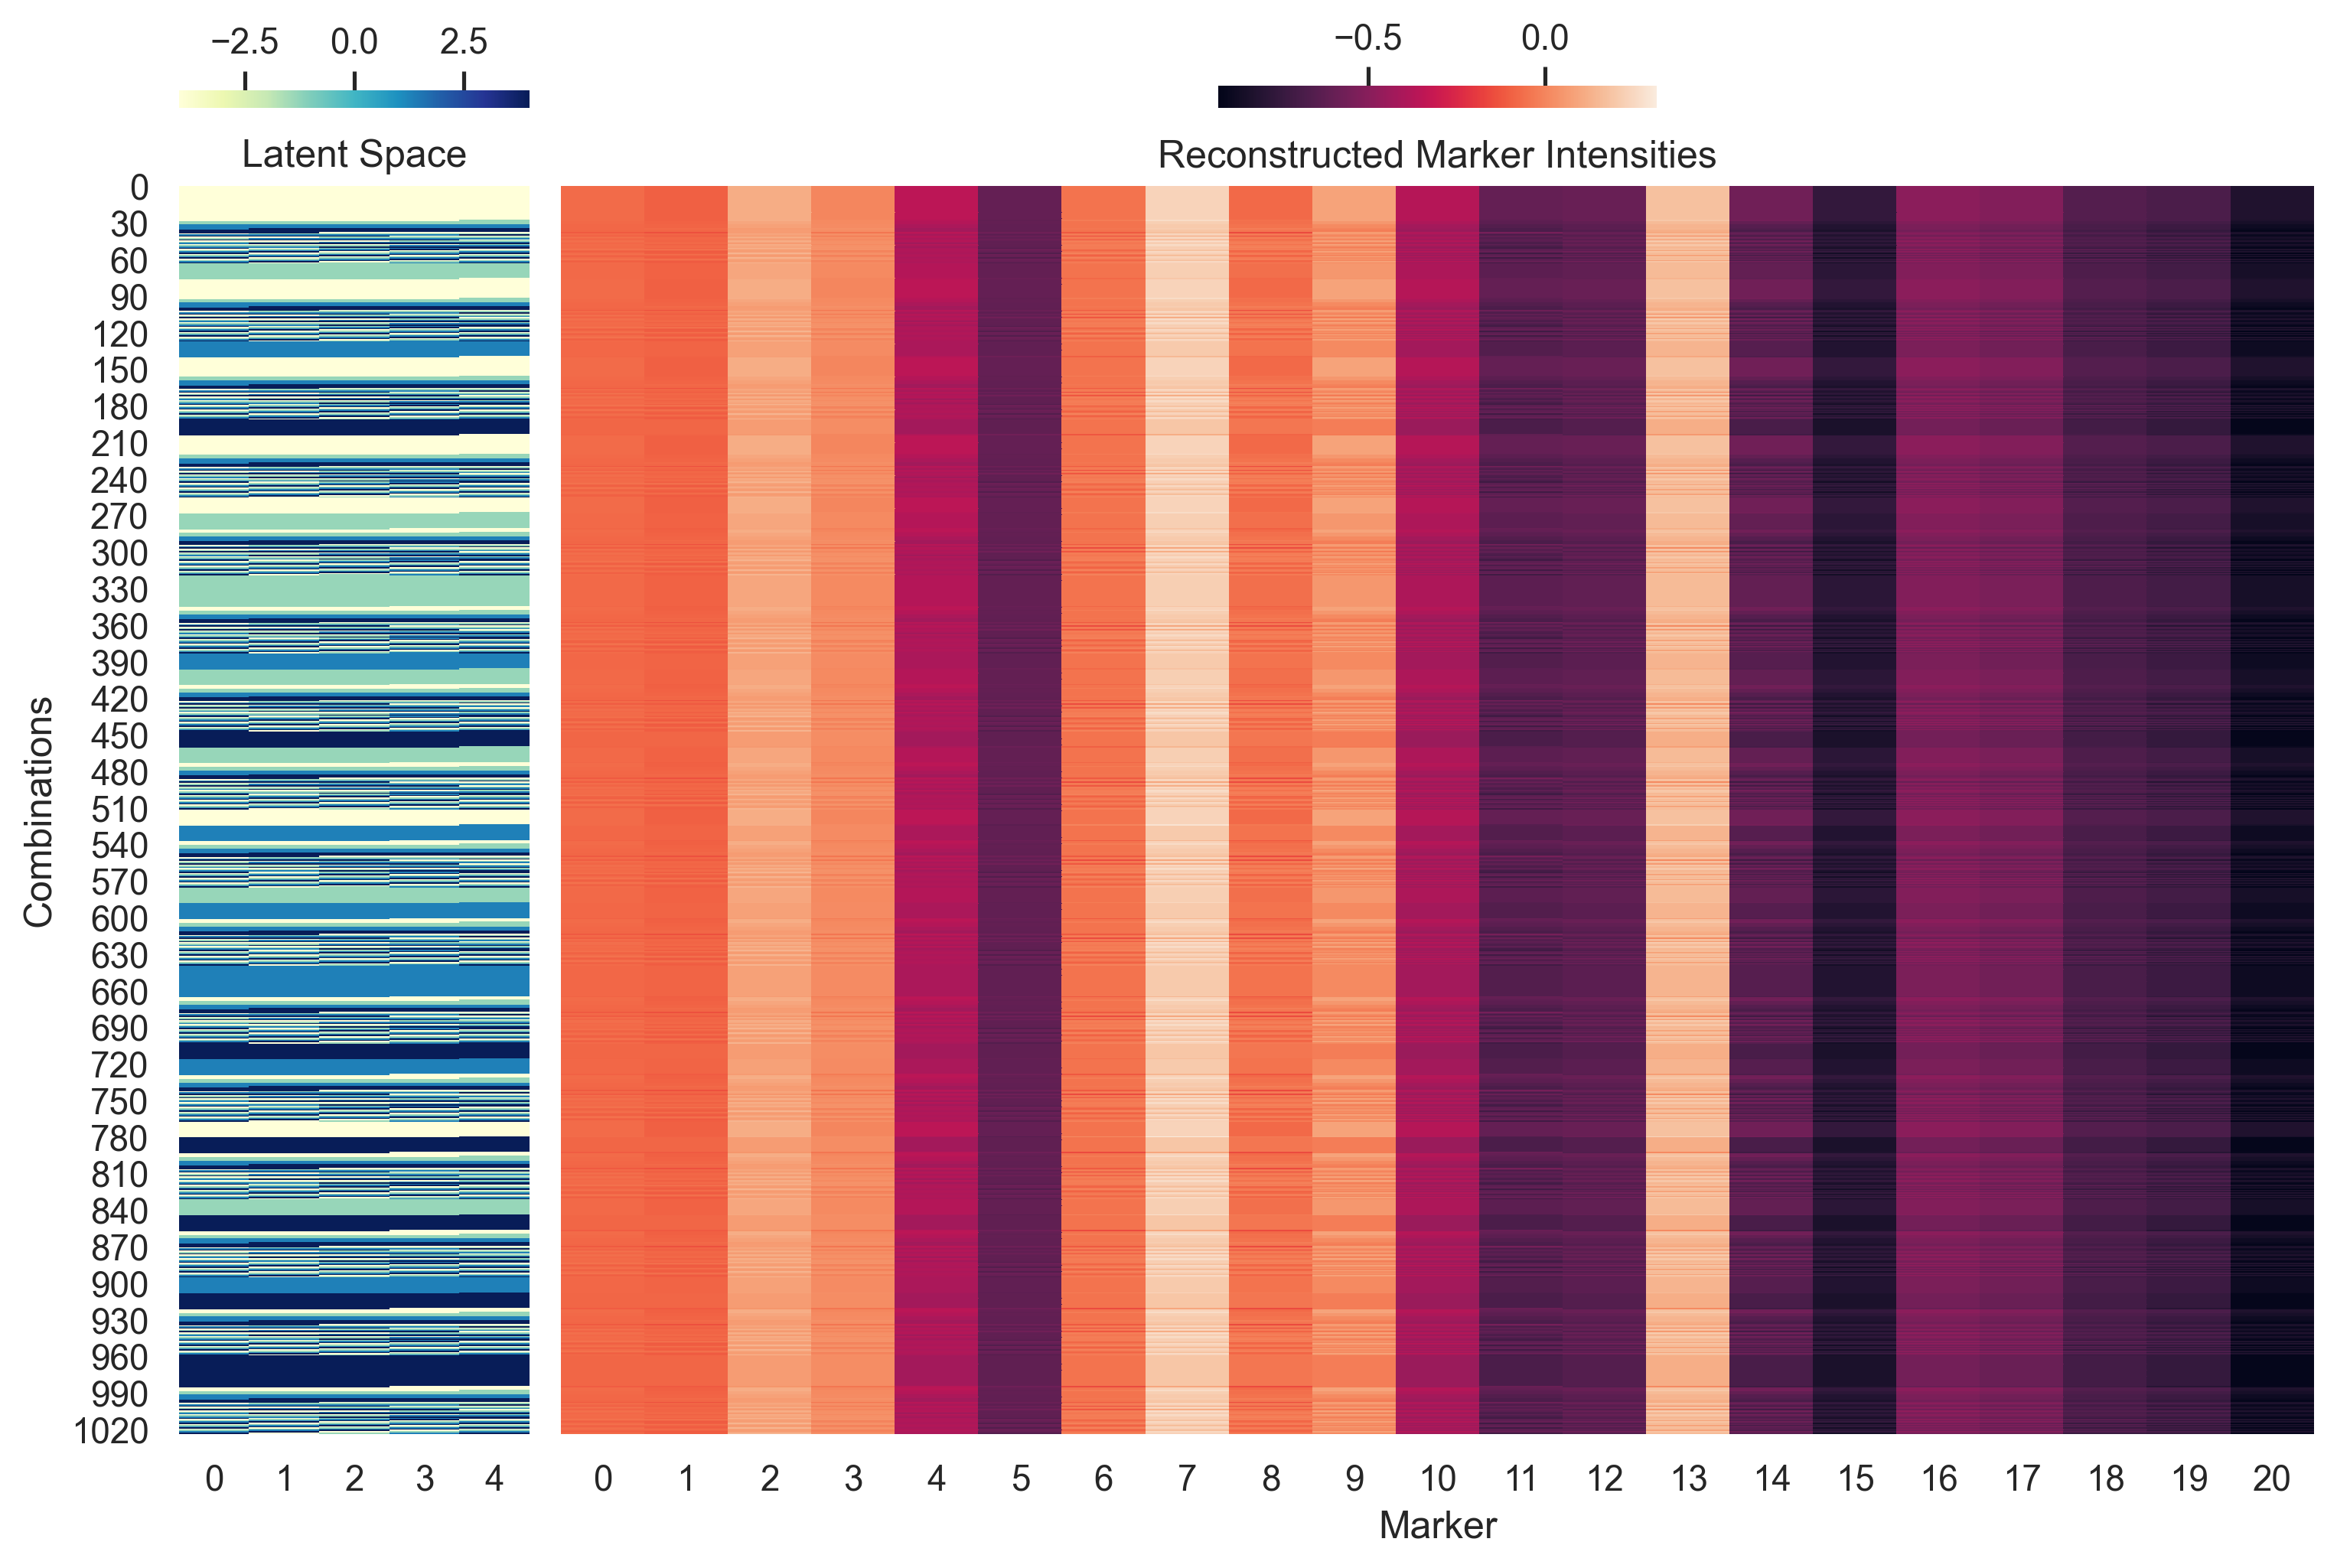

In [14]:
# Get all the possible permutations. For instance: 
# Input with three possible values for two latent 
# variables: 
# [[0.01 0.5  0.99], [0.01 0.5  0.99]]
# 
# All the possible combinations:
# [[[0.01 0.01], [0.5  0.01], [0.99 0.01]],
#  [[0.01 0.5 ], [0.5  0.5 ], [0.99 0.5 ]],
#  [[0.01 0.99], [0.5  0.99], [0.99 0.99]]]

# Linearly spaced latent variables.
# Values are transformed through the inverse CDF (PPF)
# of the Gaussian since the prior of the latent space
# is Gaussian.
step_size = 4
z = np.array([np.linspace(-4, 4, step_size)] * latent_dim)
#z = norm.ppf(z)

z_grid = np.dstack(np.meshgrid(*z))
z_grid = z_grid.reshape(step_size ** latent_dim, latent_dim)

x_pred_grid = decoder.predict(z_grid)
x_pred_grid = np.block(list(map(list, x_pred_grid)))

sns.set_theme()
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12, 9), dpi=300, gridspec_kw={'width_ratios': [1, 5]})
plt.subplots_adjust(wspace=0.03, hspace=0.1)

sns.heatmap(z_grid, ax=ax1, cmap="YlGnBu", cbar_kws=dict(use_gridspec=False,location="top"))
sns.heatmap(x_pred_grid, ax=ax2, yticklabels=False, cbar_kws=dict(use_gridspec=False,location="top", shrink=.25))

ax1.set_title("Latent Space")
ax1.set_ylabel("Combinations")

ax2.set_title("Reconstructed Marker Intensities")
ax2.set_xlabel("Marker")